In [32]:
from simple_unet import multi_unet_model
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import sys
import random

np.set_printoptions(threshold=sys.maxsize)

In [4]:
# Check GPU availability

import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
# print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.5-arm64-arm-64bit


AttributeError: module 'tensorflow.keras' has no attribute '__version__'

In [33]:
#Resizing images
SIZE_X = 640
SIZE_Y = 640
n_classes= 100 # Number of classes for segmentation

TRAIN_PATH_X = './trainingSet/origImages/'
TRAIN_PATH_Y = './trainingSet/maskImages/'

train_ids_x = next(os.walk(TRAIN_PATH_X))[2]
train_ids_y = next(os.walk(TRAIN_PATH_Y))[2]

In [34]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob(TRAIN_PATH_X):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)    

#Convert list to array for machine learning processing        
train_images = np.array(train_images)

In [35]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob(TRAIN_PATH_Y):
    for mask_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [36]:
np.unique(train_masks)

array([  0,  23,  30,  34,  45,  57,  75, 104, 135, 150, 173, 195, 197,
       225, 255], dtype=uint8)

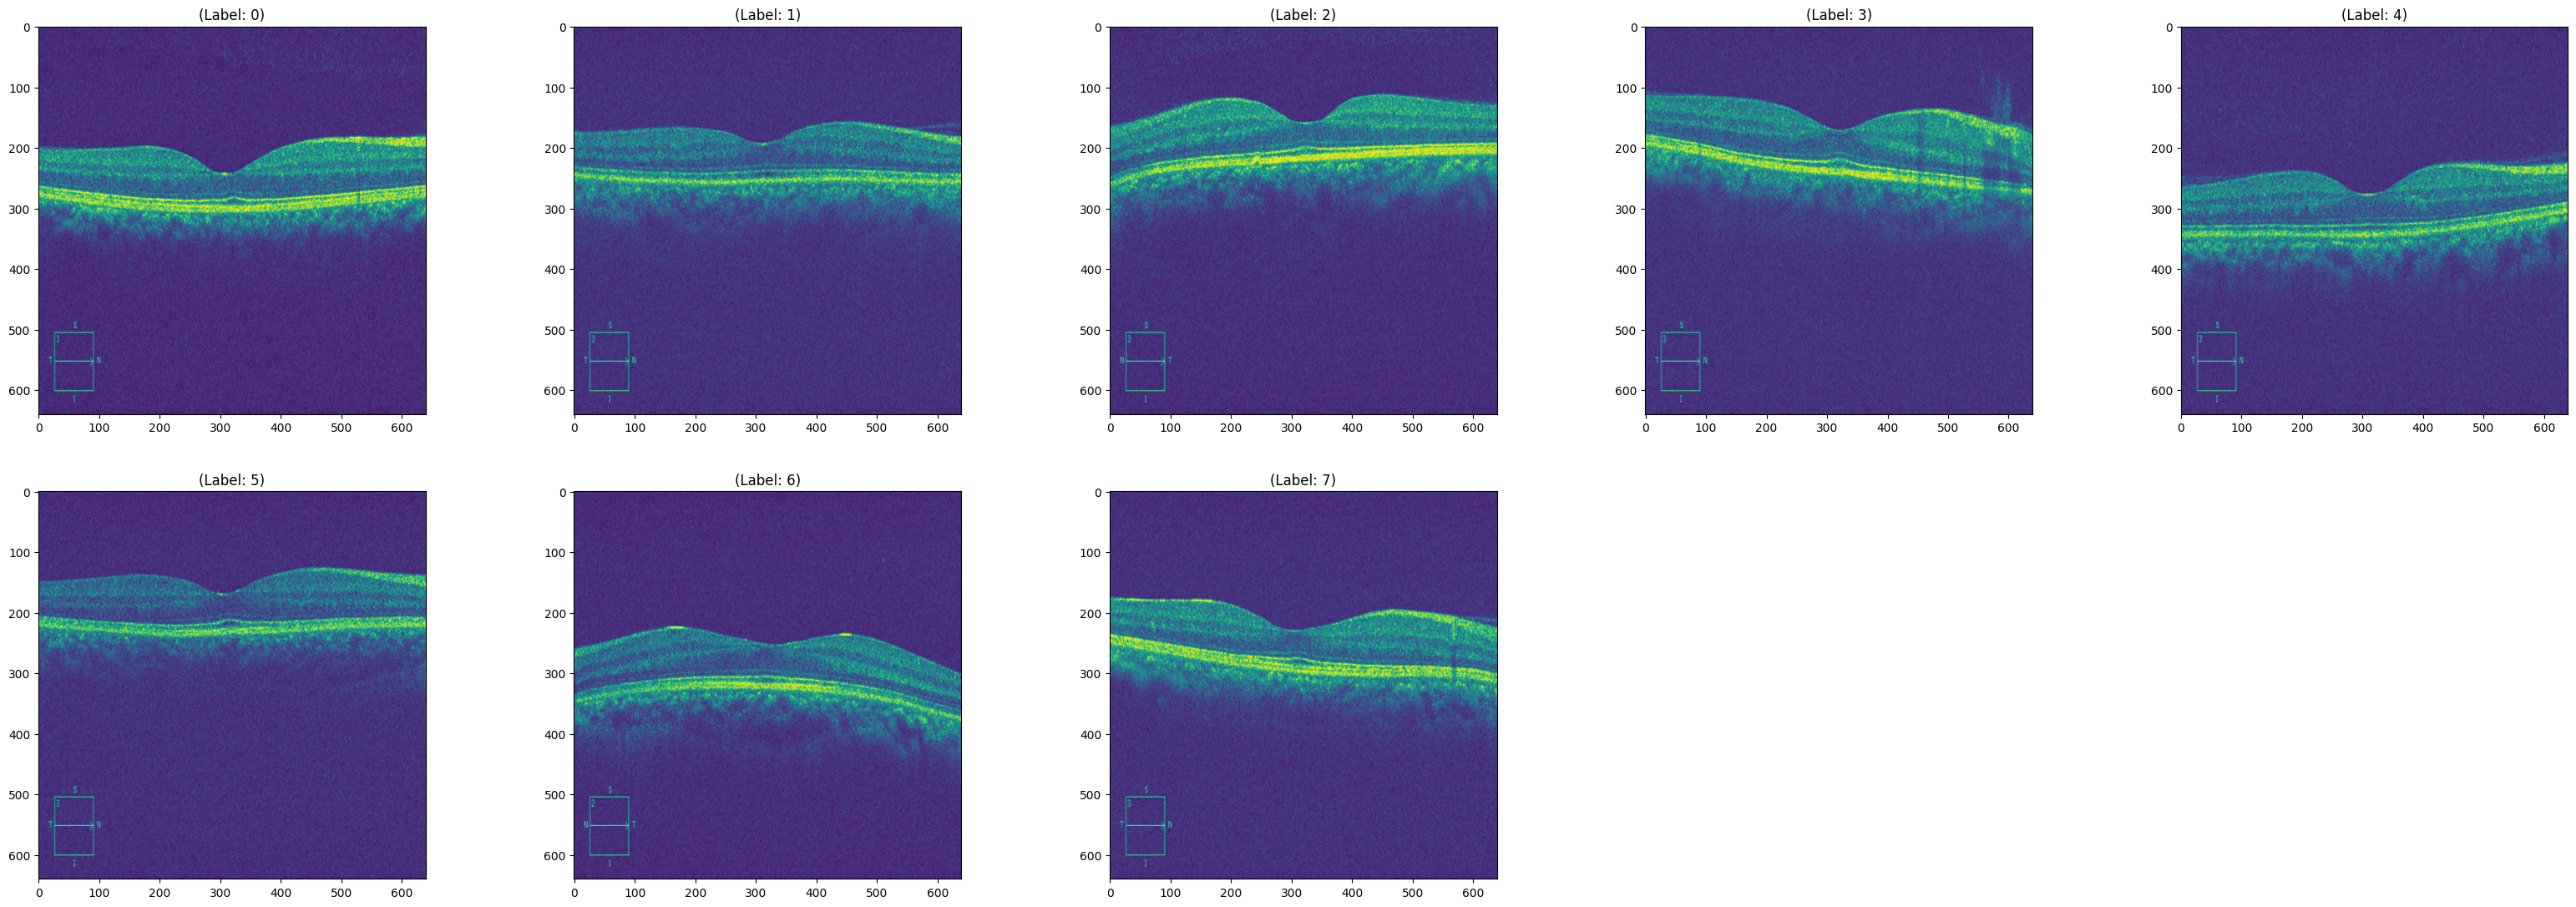

In [37]:
plt.figure(figsize=(40,100))
for i in range(8):
    plt.subplot(14, 5, i+1)
    plt.imshow(train_images[i,:,:])
    plt.title("(Label: " + str(i) + ")")
plt.show()   

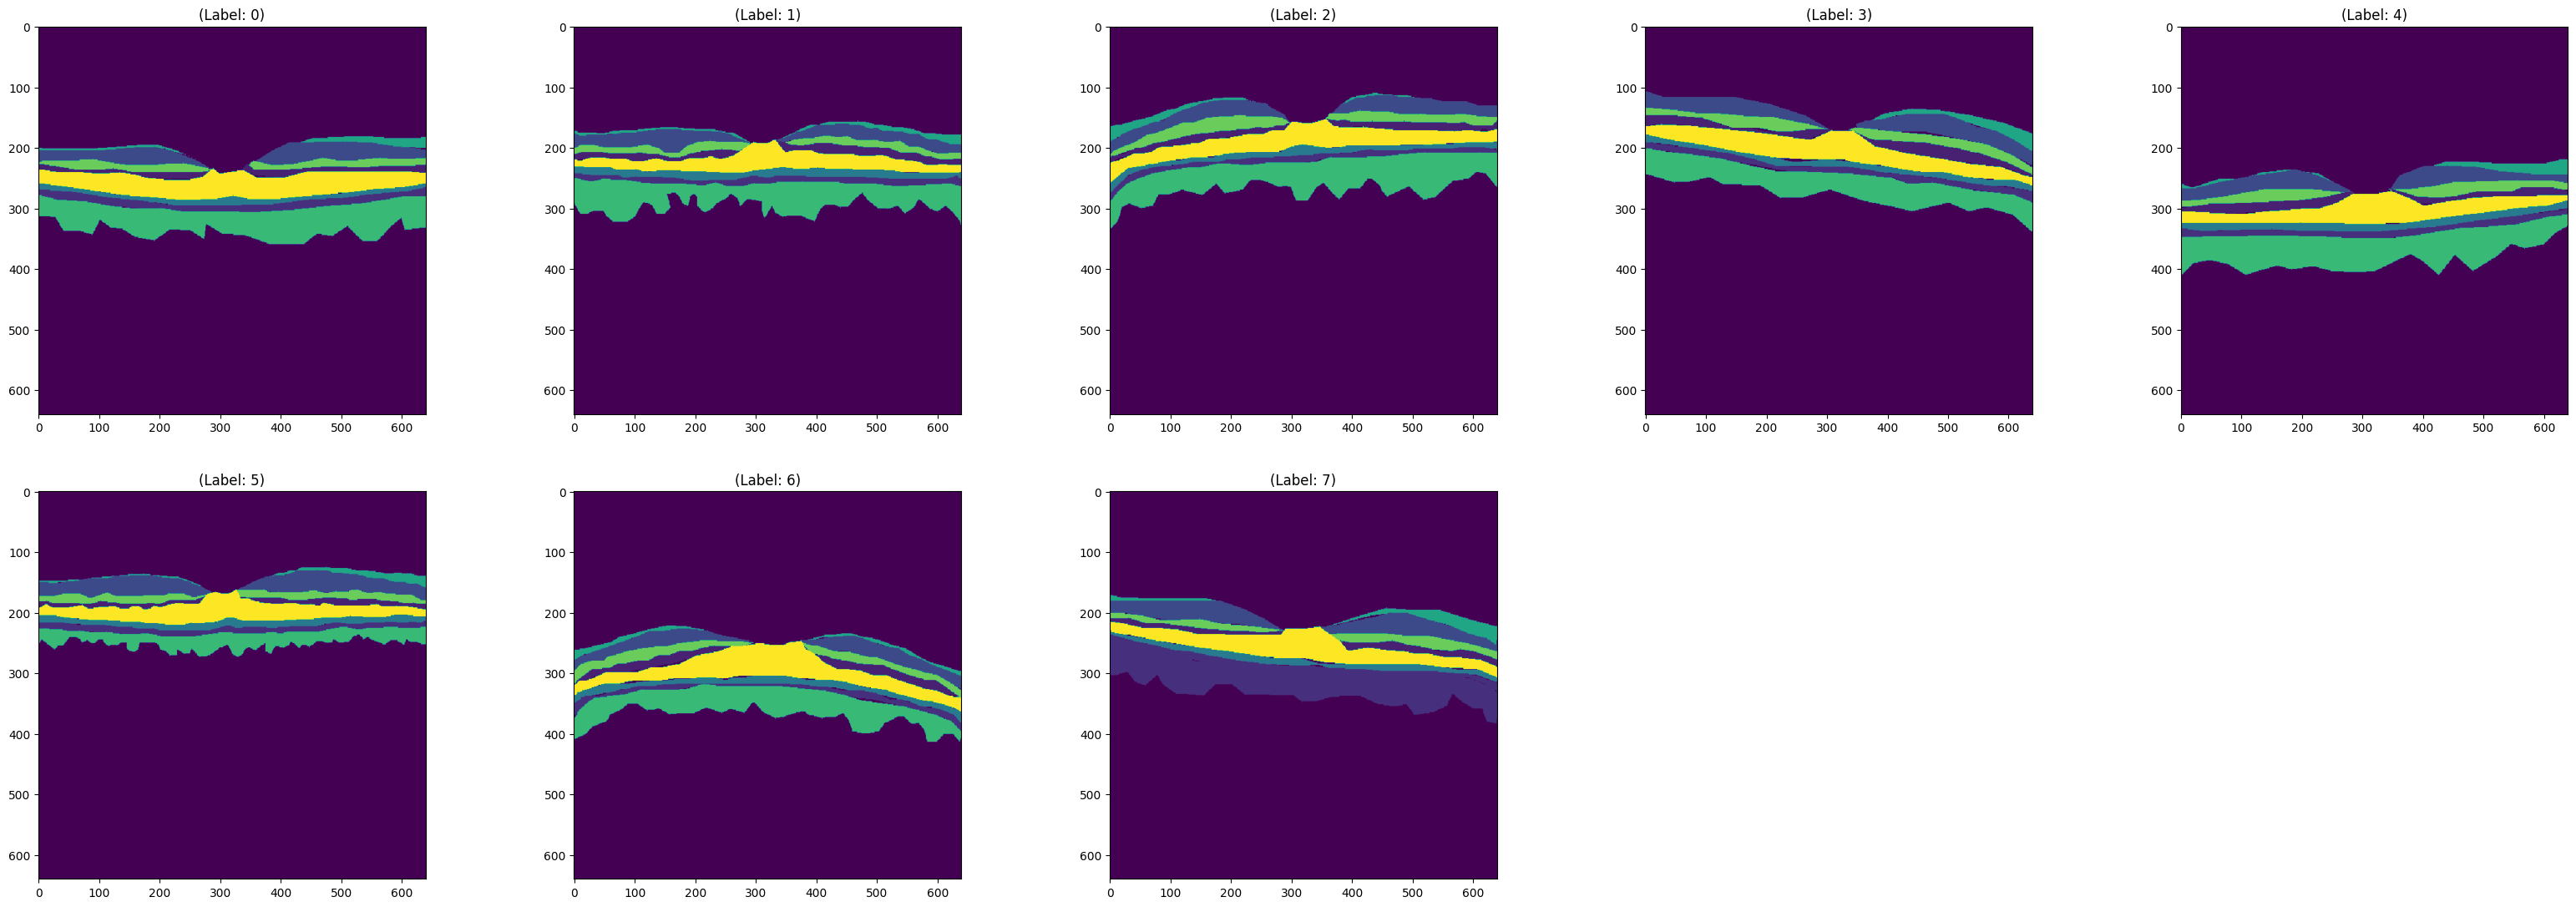

In [38]:
plt.figure(figsize=(40,100))
for i in range(8):
    plt.subplot(14, 5, i+1)
    plt.imshow(train_masks[i,:,:])
    plt.title("(Label: " + str(i) + ")")
plt.show()   

In [39]:
#Encode labels
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)


/Users/vkluzner/Private/git/DeepEye/deepeye/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [40]:

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 


Class values in the dataset are ...  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [41]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [42]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=SIZE_Y, IMG_WIDTH=SIZE_X, IMG_CHANNELS=1)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 640, 640, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 640, 640, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 640, 640, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 640, 640, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [43]:

#If starting with pre-trained weights. 
#model.load_weights('retina_segmentation_8_layer.hdf5')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=20, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
                    

_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

Epoch 1/20
5/5 [==============================] - 66s 11s/step - loss: 4.4949 - accuracy: 0.1671 - val_loss: 4.4241 - val_accuracy: 0.7373
Epoch 2/20
5/5 [==============================] - 53s 10s/step - loss: 4.2055 - accuracy: 0.6236 - val_loss: 3.7367 - val_accuracy: 0.7545
Epoch 3/20
5/5 [==============================] - 55s 11s/step - loss: 3.0861 - accuracy: 0.7283 - val_loss: 3.2351 - val_accuracy: 0.7858
Epoch 4/20
5/5 [==============================] - 53s 10s/step - loss: 2.3911 - accuracy: 0.7815 - val_loss: 2.3851 - val_accuracy: 0.7863
Epoch 5/20
5/5 [==============================] - 55s 10s/step - loss: 1.6794 - accuracy: 0.7845 - val_loss: 1.3097 - val_accuracy: 0.7863
Epoch 6/20
5/5 [==============================] - 55s 11s/step - loss: 1.1306 - accuracy: 0.7845 - val_loss: 1.0139 - val_accuracy: 0.7863
Epoch 7/20
5/5 [==============================] - 51s 10s/step - loss: 1.0129 - accuracy: 0.7845 - val_loss: 1.0079 - val_accuracy: 0.7863
Epoch 8/20
5/5 [===========

In [1]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

In [ ]:
#Using built in keras function
from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


In [ ]:
## This is example of IOU of 4 class, if you need provide corresponding amount of class 

values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])


print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

In [ ]:
# You can save your trained model by uncommenting below line

# model.save('retina_segmentation_8_layer_iter_3+20epochs.hdf5')

In [ ]:
test_img_number = 5
test_img = X_train[test_img_number]
ground_truth= y_train[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)

prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [ ]:
#Capture training image info as a list
test_test = []

test_path = "./testSet/"

for directory_path in glob.glob(test_path):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        test_test.append(img)
        print(img_path)    

#Convert list to array for machine learning processing        
test_test = np.array(test_test)

test_test = np.expand_dims(test_test, axis=3)
test_test = normalize(test_test, axis=1)

In [ ]:
test_test.shape

In [ ]:
test1 = test_test[12]
test_img_norm=test1[:,:,0][:,:,None]
test=np.expand_dims(test_img_norm, 0)

prediction = (model.predict(test))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(40, 20))

plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test1[:,:,0])

plt.subplot(232)
plt.title('Prediction<')
# plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.imshow(predicted_img, cmap='jet')

# plt.imshow(prediction[0,:,:,7], cmap='jet')


In [ ]:
prediction.shape

In [ ]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(5):
    plt.subplot(14, 5, i+1)
    plt.imshow(y_train[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()   

In [ ]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(5):
    plt.subplot(14, 5, i+1)
    plt.imshow(X_train[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()   

In [ ]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(1):
    plt.subplot(14, 5, i+1)
    plt.imshow(X_test[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()   

In [ ]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(1):
    plt.subplot(14, 5, i+1)
    plt.imshow(y_test[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()   